In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
from torch.nn import functional as F
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

/home/ubuntu/anaconda3/envs/lgch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading models and tokenizer for GPT2, GPT2-Medium and GPT-NEO-125M models


In [2]:
model_name = 'gpt2'
model_gpt = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer_gpt = GPT2Tokenizer.from_pretrained(model_name)

In [3]:
model_name_medium = 'gpt2-medium'
model_gpt_medium = GPT2LMHeadModel.from_pretrained(model_name_medium)
tokenizer_gpt_medium = GPT2Tokenizer.from_pretrained(model_name_medium)

In [4]:
model_name_neo = 'EleutherAI/gpt-neo-125M'
model_neo = GPT2LMHeadModel.from_pretrained(model_name_neo, ignore_mismatched_sizes=True)
tokenizer_neo = GPT2Tokenizer.from_pretrained(model_name_neo)

You are using a model of type gpt_neo to instantiate a model of type gpt2. This is not supported for all configurations of models and can yield errors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.10.attn.c_attn.bias', 'transformer.h.10.attn.c_attn.weight', 'transformer.h.10.attn.c_proj.bias', 'transformer.h.10.attn.c_proj.weight', 'transformer.h.11.attn.c_attn.bias', 'transformer.h.11.attn.c_attn.weight', 'transformer.h.11.attn.c_proj.bias', 'transformer.h.11.attn.c_proj.weight', 'transformer.h.2.attn.c_attn.bias', 'transformer.h.2.attn.c_attn.weight', 'transformer.h.2.attn.c_proj.bias', 'tra

- Loading Wikitext2 Dataset usind load_dataset and splitting it by test so that we get the test data only.
- Handling the empty text in the test data. 

In [5]:
# Loading wikitext2 dataset using load_dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")  # Loading dataset
texts = dataset["text"][:500]

texts = [text for text in texts if text] #handling empty records in the test set of the dataset.

- Creating a modified texts data that contais typo's, or mistakes in the sentences.
- This includes converting the to teh, what to wht, and is to iz.

In [6]:
modified_texts = []

for text in texts:
    text = text.replace('the','teh').replace('what', 'wht').replace('is','iz')
    modified_texts.append(text)     # adding text to modified texts.

# Perplexity Calculation
- First i will convert text to encoding and then passes the input-ids to the model and stores the result in the output.
- Then I will take loss from the output and calculate the perplexilty.

In [7]:
def calculate_perplexity(model, tokenizer, text):
    """
    This function calculates the perplexity of the model
    """
    # Tokenize input text
    encodings = tokenizer(text, return_tensors="pt", truncation=True) 
    # Extracting tokenized input IDs from tokenizers encodings
    input_ids = encodings.input_ids
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss                             #Retrieving loss from thhe models output.
        perplexity = np.exp(loss.item())
        return perplexity

# Calulating perplexity values for each model.
- **Step-1 :** First I will calulcate perplexity for each text in original texts data and modified texts data and store them in there respective list.
- **Step-2 :** Then I will normalize those values to bring them within a desired range. This is done to handle huge values of perplexities.
- **Step-3 :** Plotting the graph of the normalized perplexity values for original and modified data.
- **Step-4 :** Noting the observations that are seen in the graph that are plotted by comparing the two graphs.
- **Step-5 :** Plotting a line graph for line comparison of models performance on original data and modified data and noting the observation.
- **Step-6 :** Repeating the **Step-1, Step-2, Step-3, Step-4 and Step-5** for the other two models.

In [8]:
# defining scaler to scale the perplexities with a desired range of 0 to 1
scaler = MinMaxScaler()

# Model GPT2

In [9]:
#Calculating perplexities for GPT-2 on original texts and storing them ina list
perplexities_gpt = [calculate_perplexity(model_gpt, tokenizer_gpt, text) for text in texts]

# Normalizing the perplexity result by reshaping the perplexities
normalized_perplexity_gpt = scaler.fit_transform(np.array(perplexities_gpt).reshape(-1, 1)).flatten()


In [10]:
#Calculating perplexities for GPT-2 on modified texts
modified_perplexities_gpt = [calculate_perplexity(model_gpt, tokenizer_gpt, text) for text in modified_texts]

# Normalizing the modified perplexity result
normalized_modified_pplx = scaler.fit_transform(np.array(modified_perplexities_gpt).reshape(-1, 1)).flatten()

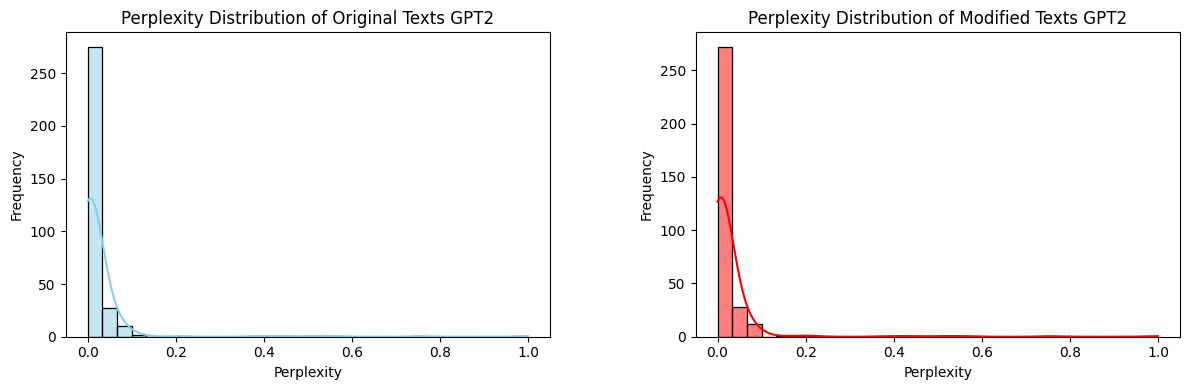

In [11]:
# Plotting the comparison graph between the perplexity distribution between the orignal text and the modified text for GPT-2

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Chart-1 for perplexity on original text 
sns.histplot(normalized_perplexity_gpt, bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Perplexity Distribution of Original Texts GPT2")
axes[0].set_xlabel("Perplexity")
axes[0].set_ylabel("Frequency")

# Chart-2 for perplexity on modified text
sns.histplot(normalized_modified_pplx, bins=30, kde=True, ax=axes[1], color="red")
axes[1].set_title("Perplexity Distribution of Modified Texts GPT2")
axes[1].set_xlabel("Perplexity")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show() 

## Observation
- It is observed for the model **GPT2** that between perplexity 0.0 to 0.035, the frequency goes above 270+ for the original texts, whereas a little fall was observed when the model was given a data with typos or mistakes(modified texts).
- Between perplexity values 0.033 to 0.066, there is a fall in frequency, which again falls below 15 indicating that the model started stuggling for word predictions
- As we move further with increase in perplexity value, it can be seen in both the graph that the frequency is almost 0.
- This shows that most of the prediction occurs in the perplexity range of 0.0 to 0.033.

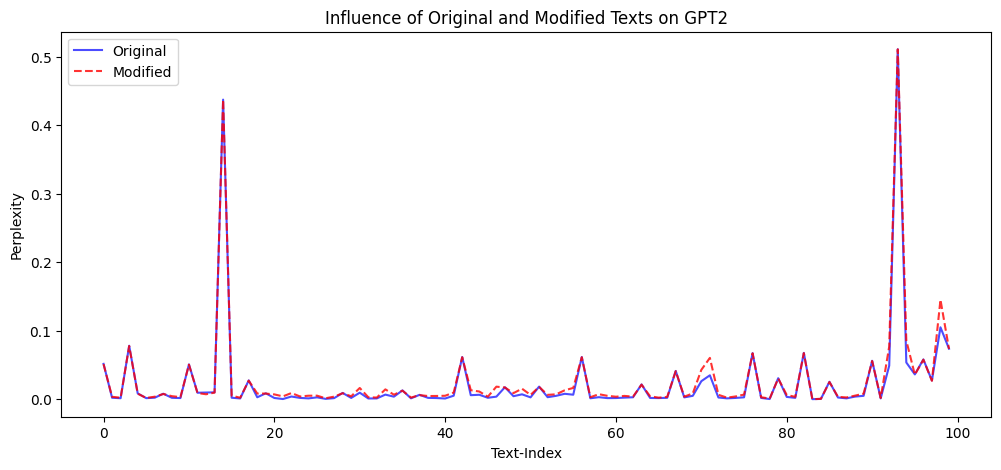

In [12]:
# Plotting graph for line comparison of models performance onn original and text data
x_label = np.arange(len(normalized_perplexity_gpt[:100]))

plt.figure(figsize=(12, 5))
plt.plot(x_label, normalized_perplexity_gpt[:100], label='Original', color='b', linestyle='-', alpha=0.7)
plt.plot(x_label, normalized_modified_pplx[:100], label='Modified', color='r', linestyle='--', alpha=0.8)

plt.xlabel("Text-Index")
plt.ylabel("Perplexity")
plt.title("Influence of Original and Modified Texts on GPT2")
plt.legend()
plt.show()

## Observations:
- The above line chart shows how the performance of the **GPT2** model is infuenced by the text modification. This data is show for the first 100 samples.
- It is observed that the models prediction for most of the text are same but it struggles to do prediction somewhat, when the text contains errors. 

# Model GPT2 Medium

In [13]:
#Calculating perplexities for GPT-2-Medium on original texts
perplexities_gpt_medium = [calculate_perplexity(model_gpt_medium, tokenizer_gpt_medium, text) for text in texts]

# Normalizing the perplexity result
normalized_perplexity_gpt_medium = scaler.fit_transform(np.array(perplexities_gpt_medium).reshape(-1, 1)).flatten()

In [14]:
#Calculating perplexities for GPT-2-Medium on modified texts
modified_perplexities_gpt_medium = [calculate_perplexity(model_gpt_medium, tokenizer_gpt_medium, text) for text in modified_texts]

# Normalizing the modified perplexity result
normalized_modified_pplx_medium = scaler.fit_transform(np.array(modified_perplexities_gpt_medium).reshape(-1, 1)).flatten()

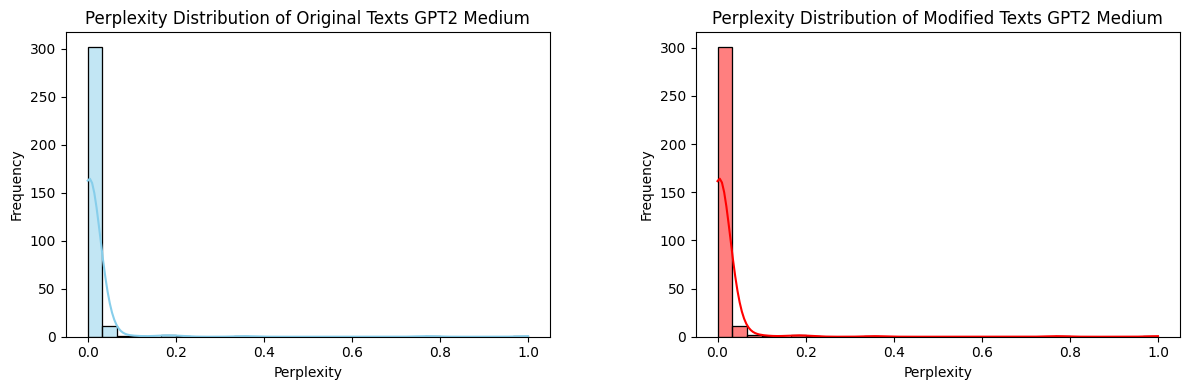

In [15]:
# Plotting the comparison graph between the perplexity distribution between the orignal text and the modified text for GPT-2-Medium
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Chart-1 for perplexity on original text 
sns.histplot(normalized_perplexity_gpt_medium, bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Perplexity Distribution of Original Texts GPT2 Medium")
axes[0].set_xlabel("Perplexity")
axes[0].set_ylabel("Frequency")

# Chart-2 for perplexity on modified text
sns.histplot(normalized_modified_pplx_medium, bins=30, kde=True, ax=axes[1], color="red")
axes[1].set_title("Perplexity Distribution of Modified Texts GPT2 Medium")
axes[1].set_xlabel("Perplexity")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show() 

## Observation
- It is observed for the model **GPT2 Medium** that between perplexity value of 0 to 0.35, the frequency goes above 300 words for original texts, whereas it is slightly less than 300 for the modified texts.
- As we move further with increase in perplexity value between 0.03 to 0.07, it can be seen in both the graph that the frequency falls below 20 in both the graphs.
- But between perplexity value 0.07 to 0.1, a very slight increase in frequency can be seen in the graph of modified texts.
- After perplexity value 0.1, there is no change in the frequency and remains almost zero.
- The both graphs for **GPT2 Medium** models appears to be the same with either no or very negligible difference.

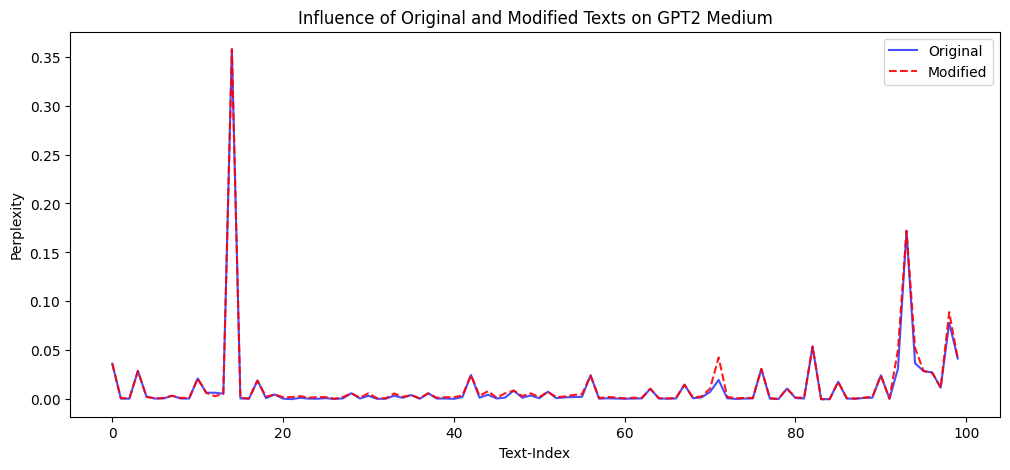

In [16]:
x_label = np.arange(len(normalized_perplexity_gpt_medium[:100]))

plt.figure(figsize=(12, 5))
plt.plot(x_label, normalized_perplexity_gpt_medium[:100], label='Original', color='b', linestyle='-', alpha=0.7)
plt.plot(x_label, normalized_modified_pplx_medium[:100], label='Modified', color='r', linestyle='--', alpha=0.9)

plt.xlabel("Text-Index")
plt.ylabel("Perplexity")
plt.title("Influence of Original and Modified Texts on GPT2 Medium")
plt.legend()
plt.show()

## Observations:
- The above line chart shows the how is the performance of the **GPT2 Medium** model infuenced by the text modification. It is for the first 100 samples.
- It perfroms slighly better when compared to **GPT2**.
- It is observed that the models prediction for most of the text are same but it struggles to do prediction somewhat, when the text contains errors. 

# Model GPT-NEO-125M

In [17]:
#Calculating perplexities for GPT-NEO-125M on original texts
perplexities_neo = [calculate_perplexity(model_neo, tokenizer_neo, text) for text in texts]

# Normalizing the perplexity result
normalized_perplexity_neo = scaler.fit_transform(np.array(perplexities_neo).reshape(-1, 1)).flatten()

In [18]:
#Calculating perplexities for GPT-NEO-125M on modified texts
modified_perplexities_neo = [calculate_perplexity(model_neo, tokenizer_neo, text) for text in modified_texts]

# Normalizing the modified perplexity result
normalized_modified_pplx_neo = scaler.fit_transform(np.array(modified_perplexities_neo).reshape(-1, 1)).flatten()

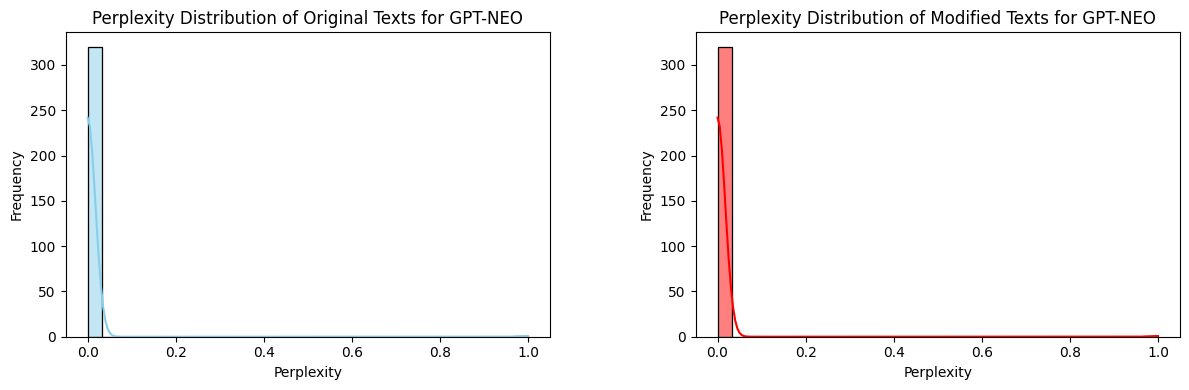

In [19]:
# Plotting the comparison graph between the perplexity distribution between the orignal text and the modified text for GPT-NEO-125M
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Chart-1 for perplexity on original text
sns.histplot(normalized_perplexity_neo, bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Perplexity Distribution of Original Texts for GPT-NEO")
axes[0].set_xlabel("Perplexity")
axes[0].set_ylabel("Frequency")

# Chart-2 for perplexity on modified text
sns.histplot(normalized_modified_pplx_neo, bins=30, kde=True, ax=axes[1], color="red")
axes[1].set_title("Perplexity Distribution of Modified Texts for GPT-NEO")
axes[1].set_xlabel("Perplexity")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show() 

## Observations
- It is observed for the **GPT-NEO-125M** model that between perplexity range 0 to 0.03, the frequency goes upto 320+ for both, the original texts and the modified texts.
- But as we move forward with the increase in perplexity values above 0.3, no change in frequency with the increase in the perplexity value can be observed in both the graphs.
- The model performance on both the orignal and the modified text appears to be the same.

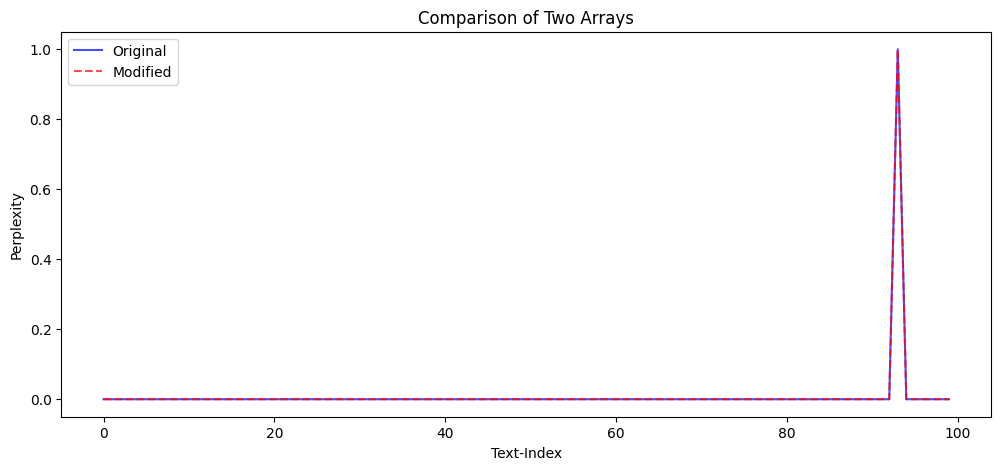

In [20]:
x_label = np.arange(len(normalized_perplexity_neo[:100]))

plt.figure(figsize=(12, 5))
plt.plot(x_label, normalized_perplexity_neo[:100], label='Original', color='b', linestyle='-', alpha=0.7)
plt.plot(x_label, normalized_modified_pplx_neo[:100], label='Modified', color='r', linestyle='--', alpha=0.7)

plt.xlabel("Text-Index")
plt.ylabel("Perplexity")
plt.title("Comparison of Two Arrays")
plt.legend()
plt.show()

## Observations:
- The above line chart shows the how is the performance of the **GPT-NEO** model infuenced by the text modification. It is for the first 100 samples.
- Its perfroms best when compared to **GPT2** and **GPT2 Medium** model.
- It is observed that the models prediction on original data and modified data is similar with either very small or with no difference.
- Thus, it is observed that **GPT-NEO-125M** performs best among the three.

# Mean Scaled Perplexity Comparison for GPT-2, GPT-2-Medium and GPT-NEO-125M
- **Step-1 :** Calculating mean of perplexities for each model based on original data and the modified data.
- **Step-2 :** Plotting the final comparison graph and noting the conclusion.

In [21]:
# Calculating the mean of each model perplexities

# Original
mean_perplexity = np.mean(normalized_perplexity_gpt)
mean_perplexity_gpt_medium = np.mean(normalized_perplexity_gpt_medium)
mean_perplexity_neo = np.mean(normalized_perplexity_neo)

# Modified
mean_modified_perplexity = np.mean(normalized_modified_pplx)
mean_modified_perplexity_gpt_medium = np.mean(normalized_modified_pplx_medium)
mean_modified_perplexity_neo = np.mean(normalized_modified_pplx_neo)

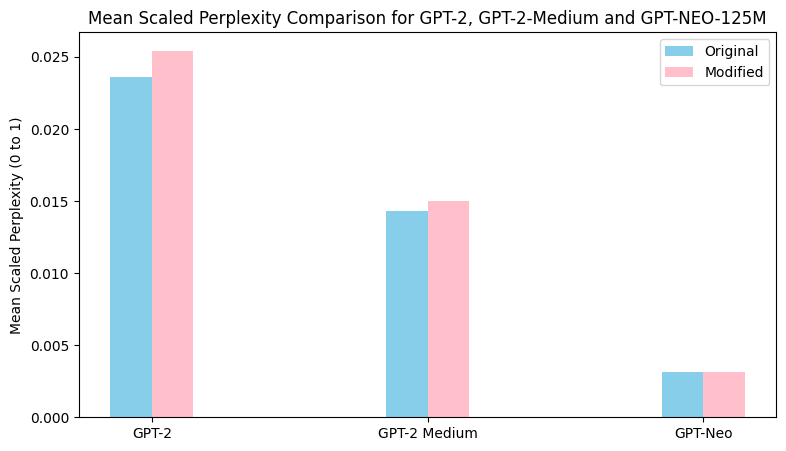

In [23]:
# Plotting the mean values calculated on original text and modified text for GPT-2, GPT-2-MEDIUM and GPT-NEO-125M

original_means = [mean_perplexity, mean_perplexity_gpt_medium, mean_perplexity_neo]
modified_means = [mean_modified_perplexity, mean_modified_perplexity_gpt_medium, mean_modified_perplexity_neo]

labels = ["GPT-2", "GPT-2 Medium", "GPT-Neo"]
x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(x - width/2, original_means, width, label="Original", color="skyblue")
ax.bar(x + width/2, modified_means, width, label="Modified", color="pink")

ax.set_ylabel("Mean Scaled Perplexity (0 to 1)")
ax.set_title("Mean Scaled Perplexity Comparison for GPT-2, GPT-2-Medium and GPT-NEO-125M")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# Conclusion
- The **Mean Scaled Perplexity Comparison** graph shows that the **GPT-2** model performs good on the test dataset with no typos or error in the words of sentences, where as it performs comparatively bad when there are mistakes in the word or sentences, thus struggling to choose words efficiently.
- The graph shows that the **GPT-2 Medium** sized model perform better than GPT-2 model but it somewhat follows the same path as that of GPT-2. It perform better on the original text than GPT-2 but does struggle to choose the word efficiently.
- The graph also shows that the **GPT-NEO-125M** is the best option among the three as it works best among them. It works better that the GPT-2 and GPT-2 Medium model on original data and on the modified data. It can be seen that the model performs almost same or with negligible difference on the original data and the modified data, thus making it the best option among the three.